# Getting started with BSCCM
This notebook demonstrates how to get started using BSCCM data. It is meant to serve both as a tutorial for how to work with the BSCCM dataset(s), as well as to provide a reference for how to use work with its most important functions


#### Table of contents:

 1. Choosing which BSCCM dataset to use
 2. How to download the data and get the code setup
 3. How to read image data
 4. Accessing global metadata
 5. Querying cell metadata
 6. Accessing processed fluorescence and surface marker data
 7. Accessing LED array field of view background data (for correcting illumination inhomogeneities)
 8. LED array calibration

## Choosing a dataset
BSCCM comes in 5 varieties: BSCCM, BSCCMNIST, BSCCM-tiny, BSCCM-coherent, and BSCCM-coherent-tiny. The "tiny" datasets are meant for prototyping using the library on a laptop without having to download the full dataset. BSCMMNIST is the same data as BSCCM, but with all images downsampled to 28x28 pixels (like the MNIST handwritten digits dataset)

**Note**: this tutorial is specific to BSCCM, not BSCCM-coherent. All of the APIs are the same, but the latter does not contain any histology-stained cells, and the names and illumination patterns of led array channels are different

### TODO: table with number of cells and features in each one (histology, multi ab, etc)

## Installing the bsccm python library
This library will provide fast, convenient access to the data and metadata

# TODO uncomment

In [1]:
# !pip install bsccm

## Downloading the data

### TODO: automatically do this from dryad?

In [20]:
import requests
import tarfile
import os

location = '/home/hpinkard_waller/2tb_ssd/'
doi_url = 'doi%3A10.5061%2Fdryad.9pg8d'
version_index = -1
file_index = 1

# Get the version ID of the dataset
api_url = "https://datadryad.org/api/v2/"
versions = requests.get(api_url + 'datasets/{}/versions'.format(doi_url))
version_id = versions.json()['_embedded']['stash:versions'][version_index]['_links']['self']['href'].split('/')[version_index]

# Get the URL to download one particular file
file = requests.get(api_url + 'versions/' + version_id + '/files').json()['_embedded']['stash:files'][file_index]
file_name = file['path']
download_url = 'https://datadryad.org' + file['_links']['stash:download']['href']

# Download in chunks (so that really big files can be downloaded)
chunk_size = 1024 * 1024 * 8
iters = file['size'] / chunk_size
with requests.get(download_url, stream=True) as r:
    r.raise_for_status()
    with open(location + file_name, 'wb') as f:
        for i, chunk in enumerate(r.iter_content(chunk_size=chunk_size)): 
            print('Downloading {}, {:.1f}%\r'.format(file_name, 100 * i / iters ), end='')
            f.write(chunk)
print('Finished downloading')


loc = location + file_name[:-7] #remove .tar.gz
print('Extracting to  {}...'.format(loc))
file = tarfile.open(location + file_name)
file.extractall(loc)
file.close()
print('Cleaning up')
os.remove(location + file_name)
print('Complete')


Finished downloadingassemblies-for-dryad.tar.gz, 99.2%
Extracting to  /home/hpinkard_waller/2tb_ssd/trinity-assemblies-for-dryad...
Cleaning up
Complete


# TODO does this extract one level too low?

## Open the dataset

Begin by importing the `BSCCM` class from the library and providing the path to a top level folder to open the dataset

In [1]:
from bsccm import BSCCM
import numpy as np
import matplotlib.pyplot as plt

data_root = '/home/hpinkard_waller/data/BSCCM/'
# data_root = '/home/hpinkard_waller/data/BSCCM-tiny/'
# data_root = '/home/hpinkard_waller/data/BSCCM-coherent/'
# data_root = '/home/hpinkard_waller/data/BSCCM-coherent-tiny/'
# data_root = '/home/hpinkard_waller/data/BSCCMNIST/'
# data_root = '/home/hpinkard_waller/data/BSCCMNIST-tiny/'

dataset = BSCCM(data_root)

Opening BSCCM
Opened BSCCM


## Reading image data
### LED array illumination

Every cell in BSCCM has a unique index, which can be used to access its data. The the full versions of the datasets, these range fom 0 to (# of cells) - 1. The Tiny versions of the datsets contain a random subsample of the full datasets, so their valid indices will not start at 0. We can figure out out what indices are present using the get_indices function

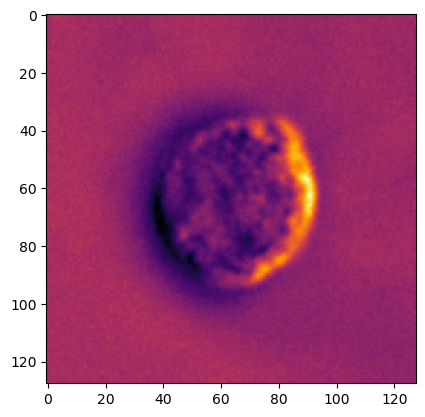

In [2]:
valid_indices = dataset.get_indices()
an_index = valid_indices[1]
image = dataset.read_image(an_index, channel='DPC_Left')
plt.imshow(image, cmap='inferno')

For all LED array images, the data are 128x128 pixels and have `uint16` data type. However, they were collected on a 12 bit camera and thus have an intensity range from 0 to 4095

Since brightfield images, which show absorbed light, often aren't the most interesting, now lets try loading a couple darkfield images and a Differential Phase Contrast (i.e. half-annulus) illumination image

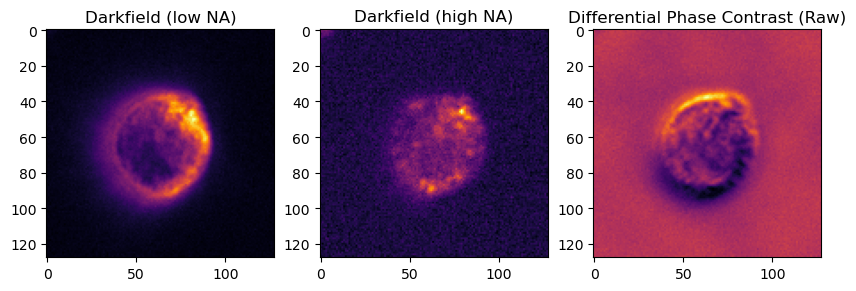

In [3]:
df_low_angle = dataset.read_image(an_index,  channel='DF_50')
df_high_angle = dataset.read_image(an_index, channel='DF_80')
dpc = dataset.read_image(an_index, channel='DPC_Top')

fig, ax = plt.subplots(1, 3, figsize=(10, 3.3))
_ = ax[0].imshow(df_low_angle, cmap='inferno')
_ = ax[0].set_title('Darkfield (low NA)')
_ = ax[1].imshow(df_high_angle, cmap='inferno')
_ = ax[1].set_title('Darkfield (high NA)')
_ = ax[2].imshow(dpc, cmap='inferno')
_ = ax[2].set_title('Differential Phase Contrast (Raw)')

### Other contrast modalities 
Besides LED array illumination, BSCCM also contains other contrast modalities:
 - **Fluorescence**, which depending on the the sub-dataset either measures the light coming from one or more surface markers, or the cell's autofluorescence. This raw data can be processed to make more information measurements of surface marker expression (described in a later section)
 - **Differential Phase Contrast (DPC)**, which is a quantitive phase contrast imaging technique. These images are included for convenience, since they can be [computed from 4 DPC LED illumination patterns](https://doi.org/10.1364/OE.23.011394) that are already included in the dataset.
 - **Histology**, Which are Giemsa stained cells imaged in brightfield. Although LED array/Fluorescence/DPC are available for all cells, histology contrast is only available for a small subset (more on this in a later section)


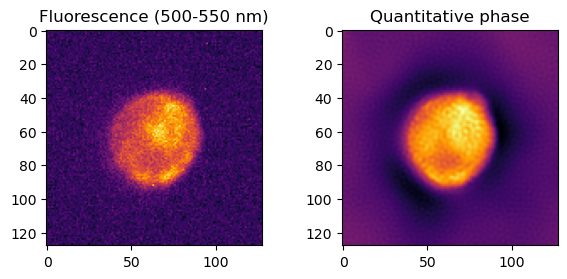

In [4]:
fluor_image = dataset.read_image(an_index,  channel='Fluor_500-550')
dpc_image = dataset.read_image(an_index , channel='dpc') 

fig, ax = plt.subplots(1,2, figsize=(7, 2.8))
_ = ax[0].imshow(fluor_image, cmap='inferno')
_ = ax[0].set_title('Fluorescence (500-550 nm)')
_ = ax[1].imshow(dpc_image, cmap='inferno')
_ = ax[1].set_title('Quantitative phase')

Unlike the previously seen contrast modalities, DPC images' dtype is `float32`

## Accessing global metadata
The easiest way to determine which channels are available in each contrast modality is to read it from the dataset's global metadata.

**Naming convention**:

    "DF" --> Darkfield
    
    "DPC" --> Differential Phase contrast
    
    "LED" --> A single LED used for illumination (more details on this below)

In [5]:
print('Fluorescence channels:')
for name in dataset.global_metadata['fluorescence']['channel_names']:
    print(name)
    
print('\nLED array channels:')
for name in dataset.global_metadata['led_array']['channel_names']:
    print(name)

Fluorescence channels:
Fluor_690-
Fluor_627-673
Fluor_585-625
Fluor_550-570
Fluor_500-550
Fluor_426-446

LED array channels:
Brightfield
DF_50
DF_50_Bottom
DF_50_Right
DF_55
DF_60
DF_60_Bottom
DF_60_Right
DF_65
DF_70
DF_70_Bottom
DF_70_Right
DF_75
DF_80
DF_80_Bottom
DF_80_Right
DF_85
DF_90
DPC_Bottom
DPC_Left
DPC_Right
DPC_Top
LED119


Global metadata also contains a bunch of other useful information like pixel size, exposure, etc

In [6]:
for key in dataset.global_metadata['led_array'].keys():
    print(key)
    
print('The illumination wavelength is: {} nm'.format(dataset.global_metadata['led_array']['wavelength_nm']))

channel_names
channel_indices
exposure_ms
wavelength_nm
pixel_size_um
objective
The illumination wavelength is: 515 nm


## Querying cell metadata
Cells can be queried and particular subpopulations sorted out by variables such as the antibody staining conditon, the biological replicate (e.g. "batch") index, the position of the cell in the field of view, etc. To do so, we'll need to query the dataset's per-cell metadata.

This metadata in a .csv, and can be conveiently accessed and queried using a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) called `index_dataframe`

In [8]:
# Show the index dataframe
dataset.index_dataframe

,position_in_fov_y_pix,position_in_fov_x_pix,detection_radius,has_matched_histology_cell,fov_center_x,fov_center_y,fov_center_z,batch,antibodies,imaging_date,data_path,slide_replicate
global_index,,,,,,,,,,,,
0,1223,556,20.48,False,-45523.16396,35464.52317,40782.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
1,906,1072,20.48,False,-45523.16396,35464.52317,40782.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
2,633,1318,20.48,False,-45523.16396,35464.52317,40782.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
3,1669,1722,20.48,False,-45505.50568,35784.71997,40782.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
4,1544,545,20.48,False,-45505.50568,35784.71997,40782.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
412936,876,1676,20.48,False,-27428.50915,22479.78837,40748.20313,1,CD14,9/10/18,antibodies_CD14/batch_1/slide_replicate_0,0
412937,691,938,12.80,False,-27428.50915,22479.78837,40748.20313,1,CD14,9/10/18,antibodies_CD14/batch_1/slide_replicate_0,0
412938,499,1524,20.48,False,-27428.50915,22479.78837,40748.20313,1,CD14,9/10/18,antibodies_CD14/batch_1/slide_replicate_0,0


Several columns here are of particular importance:
 - **has_matched_histology_cell**: True/False depending on whether there is a histology image in addition to LED array/fluorescence/DPC image
 - **batch**: Describes a batch of cells that were isolated in a single experiment. So cells with the same batch come from the same underlying population. However, they are split over many physical microscope slides, stained with different antibodies, and imaged on different dates.
 - **antibodies** Which antibodies were the cells stained with. Either is the name of a particular protein (e.g. `'CD45'`) for cells that were stained with only 1 antibody, `'all'` for cells stained with all 8 antibodies, or `'unstained'` for cells that were not stained with antibodies
 - **replicate** For **batch**/**antibody** combinations that correspond to more than 1 physical microscope slide, replicate is used to differentiate them. For the vast majority of cells, there was only a single replicate performed

Rather than having to work with this dataframe directly, bsccm has a convencience function for finding indices with particular values of these parameters:

In [9]:
# Get the global indices of cells in batch 0
global_indices = dataset.get_indices(batch=0)
print(global_indices)

[ 52923  52924  52925 ... 387715 387716 387717]


Using this function, we can find the global indices of cells that have a histology image in addition to LED Array/fluoresence/DPC images:

<Figure size 640x480 with 0 Axes>

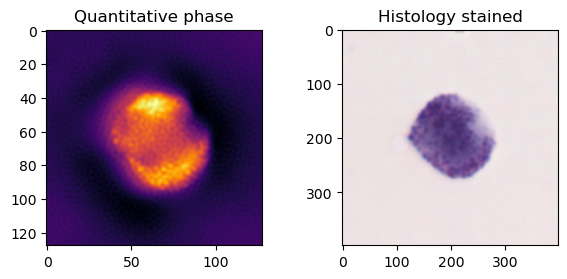

In [2]:
has_histology_indices = dataset.get_indices(has_matched_histology=True)

# plot a side by side histology and dpc image
plt.figure()

fig, ax = plt.subplots(1,2, figsize=(7, 2.8))
dpc_image = dataset.read_image(has_histology_indices[0], channel='dpc')
_ = ax[0].imshow(dpc_image, cmap='inferno')
_ = ax[0].set_title('Quantitative phase')
histology_image = dataset.read_image(has_histology_indices[0], channel='histology')
_ = ax[1].imshow(histology_image, cmap='inferno')
_ = ax[1].set_title('Histology stained')

Note that since the histology image was collected seperately with a different objective lens, it has a different resolution/pixel size/dtype

## Accessing processed fluorescence and surface marker data

An earlier section in this notebook demonstrates how to access the raw fluorescence images, but for many applications, it is more useful to access data derived from these measurements that has been: 1) corrected for inhomogenous illumination across the field of view 2) Linearly unmixed to get estimates of protein marker expression rather than raw fluorescence emssion (in which a single channel does not correspond neatly to a single antibody) 3) Summarized into low-dimensional statistics (i.e. one or a few numbers per a cell, rather than a full image). In this section we show how to access these derived data. The code for how this was derived can be found in the `fluorescence_processing` folder in this repository

All the data we're interested in here can be found in a second .csv-backed DataFrame called `surface_marker_dataframe`

In [11]:
# Show the surface_marker_dataframe dataframe
dataset.surface_marker_dataframe

,Fluor_690-_total_raw,Fluor_690-_background,Fluor_627-673_total_raw,Fluor_627-673_background,Fluor_585-625_total_raw,Fluor_585-625_background,Fluor_550-570_total_raw,Fluor_550-570_background,Fluor_500-550_total_raw,Fluor_500-550_background,...,CD19_single_antibody_model_unmixed,CD56_single_antibody_model_unmixed,CD14_single_antibody_model_unmixed,CD16_single_antibody_model_unmixed,HLA-DR_single_antibody_model_unmixed,CD3_single_antibody_model_unmixed,CD123/HLA-DR/CD14_full_model_unmixed,CD3/CD19/CD56_full_model_unmixed,CD45_full_model_unmixed,CD16_full_model_unmixed
global_index,,,,,,,,,,,,,,,,,,,,,
0,90.205154,74.643562,111.173241,92.166618,91.910187,77.581612,60.964123,58.214993,141.014313,119.545967,...,NaN,NaN,NaN,NaN,NaN,NaN,0.091213,67.815163,69.315529,2.043764
1,82.237915,75.487129,104.451164,94.646675,88.273483,79.380478,62.375282,60.246677,137.098679,121.153320,...,NaN,NaN,NaN,NaN,NaN,NaN,14.071706,51.839680,40.669029,2.043764
2,80.798347,74.069023,103.424004,92.087128,87.543541,77.186424,59.857498,57.525318,136.572571,118.782181,...,NaN,NaN,NaN,NaN,NaN,NaN,14.898065,55.368843,40.496059,2.043764
3,79.028641,74.433380,92.806908,83.702690,78.677719,69.564919,46.312710,44.212730,120.823174,105.807922,...,NaN,NaN,NaN,NaN,NaN,NaN,0.091213,61.714680,32.217438,19.714792
4,82.644333,77.617538,98.803795,88.936920,83.008171,73.497032,52.991127,50.805092,129.006073,112.741722,...,NaN,NaN,NaN,NaN,NaN,NaN,3.258880,55.699299,44.741077,2.043764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412936,74.466263,73.023483,75.277222,69.873268,63.614056,57.465630,51.774380,50.261669,98.392014,87.642433,...,NaN,NaN,53.296997,NaN,NaN,NaN,0.091213,64.467216,8.864561,38.193794
412937,75.483070,73.832535,76.499336,71.274117,64.562302,58.331261,56.651958,55.158417,99.938904,90.301842,...,NaN,NaN,52.042164,NaN,NaN,NaN,0.091213,62.686436,9.490115,36.230221
412938,72.927307,71.721359,72.462761,68.135788,60.908398,56.115700,51.587204,50.231682,93.220558,85.541161,...,NaN,NaN,52.993126,NaN,NaN,NaN,0.091213,60.968426,10.080264,36.006050


This dataframe contains many columns, including raw fluorescence measurements, shading-corrected fluorescence (i.e. corrected for position in field of view), demixed surface marker measurements, and many intermediates used in this processing. Here, we highlight two particularly useful parts, the shading-corrected fluorescence, and the demixed surface marker estimates.

These can both be accessed with another two convenience functions, the first of which is:

In [12]:
# Get the indices of cells in batch 0 with no antibody stains
global_indices = dataset.get_indices(batch=1, antibodies='unstained')
fluor = dataset.get_corrected_fluor(global_indices)

Fluor is an N by 6 matrix, where N is the number of cells and 6 is the number of fluorescent channels. Since we specifically picked `'unstained'` cells, this fluorescence corrsponds to the cell's inherent autofluorescence

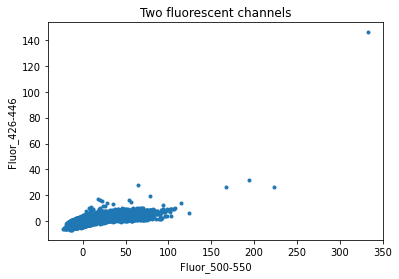

In [13]:
plt.plot(fluor[:, 4], fluor[:, 5], '.')
_ = plt.title('Two fluorescent channels')
_ = plt.xlabel(dataset.global_metadata['fluorescence']['channel_names'][4])
_ = plt.ylabel(dataset.global_metadata['fluorescence']['channel_names'][5])

### Accessing surface marker expression estimates

Rather than looking at fluorescence, we might instead want to look at surface protein expression, which have more inherent biological meaning/interpretability. BSCCM includes two versions of this, depending on which demxing model was used. More details can be found in the accomponying manuscript.

Briefly, the reason for this is that when doing unmixing (i.e. going from fluorescence --> surface marker estimates) in the case where one knows that only a single antibody was used, it is easier to make accurate estimates of surface marker expression if irrelvent spectra are excluded from the unmixing model. This motivates the "two spectra model", where the two spectra are the spectrum of the fluorophore conjugated to the antibody in question and the spectrum of the cell's inherent autofluorescence.

However, this two-spectra model won't give useful results when there are in fact many more than two antibodies present and their spectra diverge from the two in the model. In these cases, a four spectrum inversion model is used. Two of the four spectra pool together multiple antibodies that either have the exact same fluorophore, or have fluorophores that essentially indistinguishable given the fluorescence channels that were collected.

For comparison purposes, single antibody datasets were also unmixed with the four spectrum model, even though this yields suboptimal results compared to the two spectrum model.

The below example shows how to retrive the expression levels of a particular protein (using the more accurate, two-spectrum model)

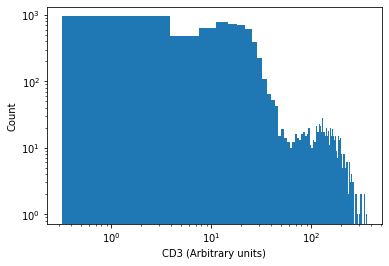

In [14]:
# Get the estimates of CD3 expression
antibody = 'CD3'
global_indices = dataset.get_indices(batch=0, antibodies=antibody)

two_spectra_model_names, two_spectra_data, four_spectra_model_names, four_spectra_data = \
                dataset.get_surface_marker_data(global_indices)

# figure out which column of the returned data corresponds to the antibody we're interested in
antibody_index = np.flatnonzero([antibody in n for n in two_spectra_model_names])[0]

# Plot a histogram of maker expression levels
_ = plt.hist(two_spectra_data[:, antibody_index], 100, log=True) 
_ = plt.xlabel(antibody + ' (Arbitrary units)')
_ = plt.ylabel('Count')
plt.xscale('log')

Now we show how to use the multi-marker model to make a scatter plot of the expression levels of two different surface proteins (on data that was treated with all antibodies at once):

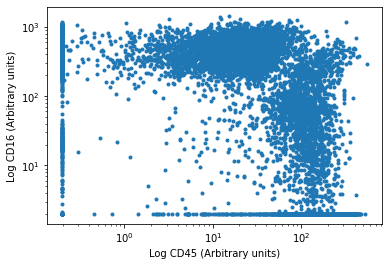

In [15]:
x_axis_antibody = 'CD45'
y_axis_antibody = 'CD16'

global_indices = dataset.get_indices(batch=0, antibodies='all')

two_spectra_model_names, two_spectra_data, four_spectra_model_names, four_spectra_data = \
                dataset.get_surface_marker_data(global_indices)

# figure out which column of the returned data corresponds to the antibody we're interested in
antibody_index_x = np.flatnonzero([x_axis_antibody in n for n in four_spectra_model_names])[0]
antibody_index_y = np.flatnonzero([y_axis_antibody in n for n in four_spectra_model_names])[0]

# Plot a histogram of maker expression levels
_ = plt.loglog(four_spectra_data[:, antibody_index_x], four_spectra_data[:, antibody_index_y], '.')
_ = plt.xlabel('Log ' + x_axis_antibody + ' (Arbitrary units)')
_ = plt.ylabel('Log ' + y_axis_antibody + ' (Arbitrary units)')


## Accessing LED array field of view background data
Many image processing algorithms, in particular computational microscopy algorithms, see improved performance by correcting for inhomogenities in illumination across the field of view. For this reason, BSCCM and BSCCM (but not the tiny versions) include additional data that is derived taking pixel-wise percentiles across many fields of view. This can be used, for example, as a pre-processing step in quantitative differential phase contrast (DPC) that improves the algorithm's performance

The background for a particular crop can be obtained with a the following convenience function:

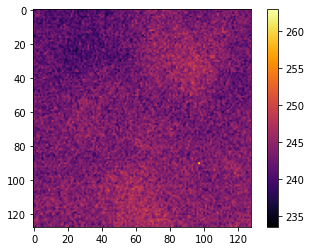

In [16]:
background = dataset.get_background(first_index, percentile=50, channel='DF_50')

_ = plt.imshow(background, cmap='inferno')
_ = plt.colorbar()

Alternatively, we can access the background for the full field of view as follows:

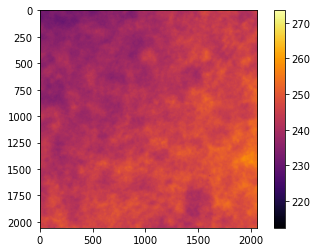

In [17]:
plt.imshow(dataset.backgrounds_and_shading['DF_50']['50_percentile'], cmap='inferno')
plt.colorbar()

## LED array calibration
Many computational imaging algorithms also require knowledge of the position and angle (i.e. the x and y numerical aperture) of the illumination. The `led_array_calibration` module provides this information

In [18]:
from bsccm.led_array_calibration import plot_led_pattern, illumination_to_led_indices, get_led_na_xy, get_led_na

# Note: LEDs are 1-indexed (i.e. there is no index 0 LED)
led_index = 119
na_xy = get_led_na_xy(led_index)

print('The x and y NA of LED {} are {:.2f}, {:.2f}'.format(led_index, *na_xy))

The x and y NA of LED 119 are 0.00, 0.40


These functions can also be used to get the led positions of multi-led patterns, and make cool plots of them

The indices of the LEDs used in the DPC_Top channel are [123 125 126 128 130 133 134 136 138 141 142 144 147 148 151 153 156 157
 159 161 163 164 166 169 170 172 174 176 178 181 182 185 186 187 189 190
 192 195 196 198 200 204 205]


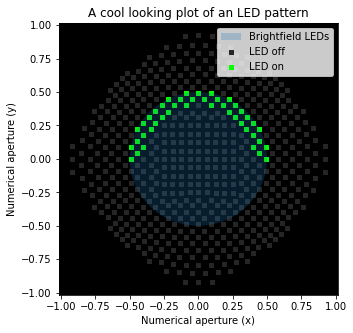

In [19]:
channel_name = 'DPC_Top'

led_indices = illumination_to_led_indices('DPC_Top')
print('The indices of the LEDs used in the {} channel are {}'.format(channel_name, led_indices))

plt.figure(figsize=(5,5))
plot_led_pattern(channel_name=channel_name, size=20)
_ = plt.title('A cool looking plot of an LED pattern')

## Computing quantitative phase images with with quantitative differential phase contrast

Quantitative phase images can be computed from a series of intensity measurements taken with annular patterns on the LED array, as described in: [Lei Tian and Laura Waller, "Quantitative differential phase contrast imaging in an LED array microscope," Opt. Express 23, 11394-11403 (2015) ](doi.org/10.1364/OE.23.011394)

The code below shows how the "raw" DPC images taken with annular illumination can be converted to a quantitatibe phase image

Text(0.5, 1.0, 'Quantitative phase')

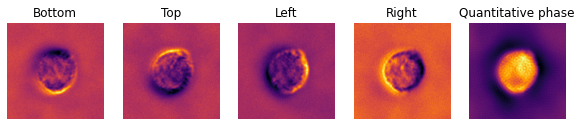

In [20]:
from bsccm import generate_wotf, generate_source, annular_sources, compute_pupil_support, tikhinov_solver

# Offset of the camera
offset = 30
# Inner and outer NA for the annulare DPC patterns
NA = 0.5
annulus_inner_NA = 0.40
# rotation of the DPC patterns
rotation = [180, 0, 90, 270]  # degree
dpc_raw_channels = ['DPC_Bottom', 'DPC_Top', 'DPC_Left', 'DPC_Right']
wavelength_um = dataset.global_metadata['led_array']['wavelength_nm'] / 1000
pixel_size = dataset.global_metadata['led_array']['pixel_size_um'] #pixel size at the object

raw_dpc_images = np.array([dataset.read_image(first_index, contrast_type='led_array', channel=c) 
                  for c in dpc_raw_channels])

# Create forward model of imaging system
sources = annular_sources(NA, annulus_inner_NA, rotation, raw_dpc_images.shape[-2:], wavelength_um, pixel_size)
pupil = compute_pupil_support(wavelength_um, NA, pixel_size, raw_dpc_images.shape[-2:])
Hu, Hp = generate_wotf(sources, pupil)
        
# Perform shaidng correction
shading = [dataset.get_background(first_index, percentile=50, channel=c) - offset for c in dpc_raw_channels]
dpc_inputs = (raw_dpc_images - offset) / shading

# Solve qDPC inverse problem
dpc = tikhinov_solver(dpc_inputs, sources, pupil, Hu, Hp)
phase = dpc.imag[0]

# Make plots
fig, ax = plt.subplots(1,5, figsize=(10, 2))
for im, a, name in zip(raw_dpc_images, ax[:4], ['Bottom', 'Top', 'Left', 'Right']):
    a.imshow(im, cmap='inferno')
    a.set_axis_off()
    a.set_title(name)

ax[-1].imshow(phase, cmap='inferno')
ax[-1].set_axis_off()
ax[-1].set_title('Quantitative phase')